# Final Project on Factorization Machines

    - Author: Joey Gu (zg2319) & Sabrina Li (zl2728)
        
    - Objective: This project aims to explore the effects of sample techniques and side information on factorization machines using MovieLens dataset.

## Read Data

The MovieLens dataset can be found here: 
Due to the limit of running time and system capacity, we used a sample of 2 million records.

In [3]:
import numpy as np
import pandas as pd
import scipy.sparse as sps
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
from math import sqrt
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from lightfm._lightfm_fast import CSRMatrix, calculate_auc_from_rank
from collections import defaultdict

/anaconda3/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [4]:
ml = pd.read_csv("ratings.csv")

In [5]:
ml = ml.sample(frac=0.1, random_state = 50)

## Sampling 

### Subsample by users/items

To subsample the dataset based on how many items they have rated, we first sort the users by number of movies they have rated, then sample the dataset k times by sparsity, which makes the subset we generate each time more and more well-populated.

### Subsample by size

Next, we subsample the dataset by proportion to see how sample size is related to the performance of our model. We take sample from 10% to 100% of the original dataset and measure the evaluation by accuracy and coverage.




In [6]:
#create a dataframe to store userid and number of movies each user has rated
df_user = ml.groupby('userId').count().reset_index()
user_movie = df_user.iloc[:,:2]
user_movie.columns = ['userId', "movie_num"]
user_movie.sort_values(by='movie_num', ascending=1, inplace = True)

## Evaluation Metrics

### Accuracy

    - RMSE
    - Precision
    - Recall


### Coverage
    - Item coverage
    - User coverage
    - Catalog coverage


In [7]:
## Accuracy

def precisionk(rank, ml, k = 10):
    
    ranks = rank
    ranks.data = np.less(ranks.data, k, ranks.data)
    precision = np.squeeze(np.array(ranks.sum(axis=1))) / k
    precision = precision[ml.getnnz(axis=1) > 0]
    
    return precision.mean()


def recallk(rank, ml, k = 10):
    
    ranks = rank
    ranks.data = np.less(ranks.data, k, ranks.data)
    retrieved = np.squeeze(ml.getnnz(axis=1))
    hit = np.squeeze(np.array(ranks.sum(axis=1)))
    hit = hit[ml.getnnz(axis=1) > 0]
    retrieved = retrieved[ml.getnnz(axis=1) > 0]

    return (hit / retrieved).mean()

def aucscore(rank, ml, num_threads=1):
    
    ranks = rank
    assert np.all(ranks.data >= 0)

    auc = np.zeros(ranks.shape[0], dtype=np.float32)

    num_train_positives = np.zeros(ml.shape[0], dtype=np.int32)

    calculate_auc_from_rank(CSRMatrix(ranks),
                            num_train_positives,
                            ranks.data,
                            auc,
                            num_threads)

    auc = auc[ml.getnnz(axis=1) > 0]

    return auc.mean()

def compute_RMSE(pred, original):
    n = len(pred)
    RMSE = sqrt(sum((pred-original)**2)/n)
    return RMSE


In [8]:
## Coverage 

#get top_n, number of items, number of users

def get_topn_nu_ni(df, pred, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''
    
    df['pred'] = pred
    predictions = df.values.tolist()

    # First map the predictions to each user.
    top_n = defaultdict(list)
    
    for uid, iid, true_r, time, est in predictions:
        top_n[uid].append((iid, est, true_r))
    
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
        
    #create a list to store items
    items = []
    for uid, iid, true_r, time, est in predictions:
        if iid not in items:
            items.append(iid)
    n_items = len(items)
    
    #create a list to store users
    users = []
    for uid, iid, true_r, time, est in predictions:
        if uid not in users:
            users.append(iid)
    n_users = len(users)

    
    return top_n, n_users, n_items




#catalog-coverage
def cata_cov(top_n, n_items):
    '''Return the the catalog-coverage.

    Args:
        top_n (A dict where keys are user (raw) ids and values are lists of tuples):
        [(raw item id, rating estimation, true rating), ...] of size n.
        n_items (int): the total number of items of the dataset.
    
    Returns:
    A float presenting catalog-coverage.
    '''
    #create a list to store the items recommended
    l = []
    for i in range(1, len(top_n) + 1, 1):
        for item in top_n[i]:
            if item[0] not in l:
                l.append(item[0])
    return (float(len(l)) / float(n_items))


#user-coverage
def user_cov(top_n, n_users, k = 3):
    '''Return the the user-coverage for which at least k items' ratings reach 4 from a recommendation dict.

    Args:
        top_n (A dict where keys are user (raw) ids and values are lists of tuples):
        [(raw item id, rating estimation, true rating), ...] of size n.
        n_users (int): Number of users.
        k (int): Default is 5.
    
    Returns:
    A float presenting user-coverage.
    '''
    
    #create a dict to store the users' recommended items whose ratings reach 4
    #count = count + 1 if the i-th user has more than k recommended well items
    user_cover = defaultdict(list)
    count = 0
    for i in range(len(top_n)):
        for item in top_n[i]:
            if item[2] >= 4:
                user_cover[i].append(item)
        if len(user_cover[i]) >= k:
            count += 1
    return (float(count)/float(n_users))


#item-coverage
def item_cov(top_n, n_items, k = 1):
    '''Return the the number of items at least recommended to k users 
       whose ratings reach 4 from a recommendation dict.

    Args:
        top_n (A dict where keys are user (raw) ids and values are lists of tuples):
        [(raw item id, rating estimation), ...] of size n.
        n_items (int): the total number of items of the dataset.
        k (int): Default is 1.
    
    Returns:
    An integar presenting the number of users
    '''
    
    #create a dict to store the items whose ratings reach 4 and the users they're recommended to
    item_cover = defaultdict(list)
    count = 0
    for i in range(len(top_n)):
        for item in top_n[i]:
            if item[2] >= 4:
                item_cover[item[0]].append(item)
                
    #count = count + 1 if the i-th item has more than k users
    for i in range(n_items):
        if len(item_cover[i]) >= k:
            count += 1
    return (float(count) / float(n_items))

## Factorization Machines (FM)

### Matrix Factorization (MF) - No side information

We first look at the performance of Matrix Factorization using our FM model with only information about users and items.

In [35]:
def nmlz(l):
    x_min = min(l)
    x_max = max(l)
    scale = x_max - x_min
    ll = []
    for i in range(len(l)):
        ll.append((l[i] - x_min)/scale*4 + 1)
    ll = np.array(ll)
    return ll


def mf_accuracy(ml, precision = True):
    '''
    Input: 
        - ml: the selected dataframe of ratings
        
    Output:
        - RMSE_train, RMSE_test
        
    '''
    #Split training and test sets
    ml_train_df = ml.sample(frac=0.7, random_state = 50)
    ml_test_df = ml.drop(ml_train_df.index)
    
    #Shape here is the number of users (given by README.txt) * number of items (given by movies.csv)

    #Convert training set into coo matrix
    user_train = np.array(ml_train_df.loc[:,"userId"] - 1)
    item_train = np.array(ml_train_df.loc[:,"movieId"] - 1)
    rating_train = np.array(ml_train_df.loc[:,"rating"])
    ml_train = sps.coo_matrix((rating_train, (user_train, item_train)), shape = (138493, 131262))

    #Convert test set into coo matrix
    user_test = np.array(ml_test_df.loc[:,"userId"] - 1)
    item_test = np.array(ml_test_df.loc[:,"movieId"] - 1)
    rating_test = np.array(ml_test_df.loc[:,"rating"])
    ml_test = sps.coo_matrix((rating_test, (user_test, item_test)), shape = (138493, 131262))

    model = LightFM()
    %time model.fit(ml_train)
    
    #Predict the model
    ml_train_pre = model.predict(user_train, item_train)
    ml_train_pre = nmlz(ml_train_pre)
    ml_test_pre = model.predict(user_test, item_test)
    ml_test_pre = nmlz(ml_test_pre)
    
    RMSE_train = compute_RMSE(ml_train_pre, rating_train)
    RMSE_test = compute_RMSE(ml_test_pre, rating_test)
    
    if precision == False:
        return RMSE_train, RMSE_test
    
    rank_train = model.predict_rank(ml_train)
    train_precision = precisionk(rank_train, ml_train, k=10).mean()
    rank_test = model.predict_rank(ml_test)
    test_precision = precisionk(rank_test, ml_test, k=10).mean()


    start_time = time.time()
    train_auc = auc_score(model, ml_train).mean()
    test_auc = auc_score(model, ml_test).mean()
    print("AUC: --- %s seconds ---" % (time.time() - start_time))
    
    start_time = time.time()
    top_n_train, n_users_train, n_items_train = get_topn_nu_ni(ml_train_df, ml_train_pre)
    top_n_test, n_users_test, n_items_test = get_topn_nu_ni(ml_test_df, ml_test_pre)
    print("Top n: --- %s seconds ---" % (time.time() - start_time))
    
    start_time = time.time()
    ctcv_train = cata_cov(top_n_train, n_items_train)
    ctcv_test = cata_cov(top_n_test, n_items_test)
    print("Cata coverage: --- %s seconds ---" % (time.time() - start_time))
    
    start_time = time.time()
    uscv_train = user_cov(top_n_train, n_users_train)
    uscv_test = user_cov(top_n_test, n_users_test)
    print("User coverage: --- %s seconds ---" % (time.time() - start_time))
    
    start_time = time.time()
    itcv_train = item_cov(top_n_train, n_items_train)
    itcv_test = item_cov(top_n_test, n_items_test)
    print("Item coverage: --- %s seconds ---" % (time.time() - start_time))
    
    
    
    return RMSE_train, RMSE_test, train_precision, test_precision, train_auc, test_auc,ctcv_train, ctcv_test, uscv_train, uscv_test, itcv_train, itcv_test




In [8]:
###Sample by user - MF
iteration = 50
step = 5

RMSE_train_mf = []
RMSE_test_mf = []
Precision_train_mf = []
Precision_test_mf = []
AUC_train_mf = []
AUC_test_mf = []
CTCV_train_mf = []
CTCV_test_mf = []
USCV_train_mf = []
USCV_test_mf = []
ITCV_train_mf = []
ITCV_test_mf = []

index = int(len(user_movie)/iteration)
for i in range(0, iteration-step, step):
    size = list(range(i*index, (i+3)*index))
    user_selected = user_movie.iloc[size, 0]
    ml_selected = ml.loc[ml['userId'].isin(user_selected)]
    rmse_train, rmse_test, train_precision, test_precision, train_auc, test_auc,ctcv_train, ctcv_test, uscv_train, uscv_test, itcv_train, itcv_test = mf_accuracy(ml_selected)
    RMSE_train_mf.append(rmse_train)
    RMSE_test_mf.append(rmse_test)
    Precision_train_mf.append(train_precision)
    Precision_test_mf.append(test_precision)
    AUC_train_mf.append(train_auc)
    AUC_test_mf.append(test_auc)
    CTCV_train_mf.append(ctcv_train)
    CTCV_test_mf.append(ctcv_test)
    USCV_train_mf.append(uscv_train)
    USCV_test_mf.append(uscv_test)
    ITCV_train_mf.append(itcv_train)
    ITCV_test_mf.append(itcv_test)
    

sample_plot = pd.DataFrame(
{
    'sparsity': list(range(0, iteration-step, step)),
    'RMSE_train': RMSE_train_mf,
    'RMSE_test': RMSE_test_mf,
    'precision_train': Precision_train_mf,
    'precision_test': Precision_test_mf,
    'AUC_train': AUC_train_mf,
    'AUC_test': AUC_test_mf,
    'Catalog_coverage_train': CTCV_train_mf,
    'Catalog_coverage_test': CTCV_test_mf,
    'User_coverage_train': USCV_train_mf,
    'User_coverage_test': USCV_test_mf,
    'Item_coverage_train': ITCV_train_mf,
    'Item_coverage_test': ITCV_test_mf
    
    
})


   
    

CPU times: user 63.5 ms, sys: 19.1 ms, total: 82.6 ms
Wall time: 82.7 ms
AUC: --- 45.18280100822449 seconds ---
Top n: --- 0.2853250503540039 seconds ---
Cata coverage: --- 0.0029449462890625 seconds ---
User coverage: --- 0.009395122528076172 seconds ---
Item coverage: --- 0.005042076110839844 seconds ---
CPU times: user 70.5 ms, sys: 21.2 ms, total: 91.8 ms
Wall time: 92.3 ms
AUC: --- 66.19737982749939 seconds ---
Top n: --- 0.999290943145752 seconds ---
Cata coverage: --- 0.03105926513671875 seconds ---
User coverage: --- 0.014660120010375977 seconds ---
Item coverage: --- 0.009177207946777344 seconds ---
CPU times: user 72 ms, sys: 18.6 ms, total: 90.6 ms
Wall time: 90.6 ms
AUC: --- 157.51417803764343 seconds ---
Top n: --- 2.315774917602539 seconds ---
Cata coverage: --- 0.014169931411743164 seconds ---
User coverage: --- 0.016889095306396484 seconds ---
Item coverage: --- 0.015429019927978516 seconds ---
CPU times: user 77.8 ms, sys: 19.2 ms, total: 96.9 ms
Wall time: 97 ms
AUC: 

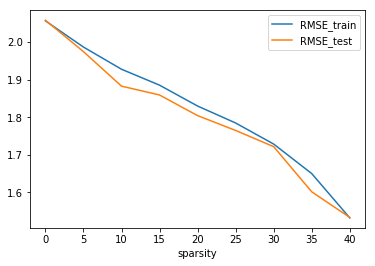

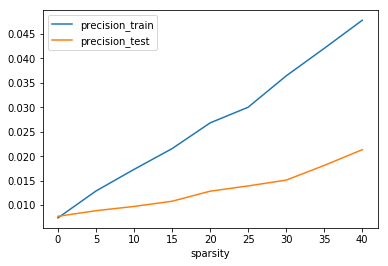

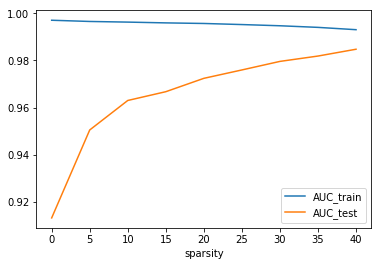

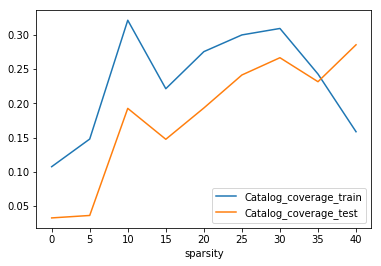

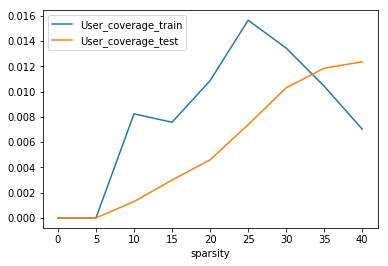

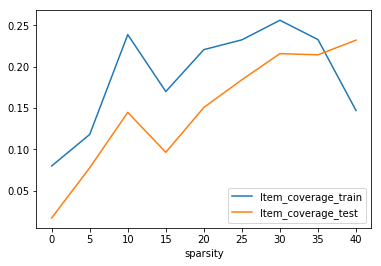

In [9]:
#Plot the performance of MF model
fig = sample_plot.plot(x = 'sparsity', y = ['RMSE_train', 'RMSE_test'])
plt.show() 
fig = sample_plot.plot(x = 'sparsity', y = ['precision_train', 'precision_test'])
plt.show() 
fig = sample_plot.plot(x = 'sparsity', y = ['AUC_train', 'AUC_test'])
plt.show() 
fig = sample_plot.plot(x = 'sparsity', y = ['Catalog_coverage_train', 'Catalog_coverage_test'])
plt.show()
fig = sample_plot.plot(x = 'sparsity', y = ['User_coverage_train', 'User_coverage_test'])
plt.show()
fig = sample_plot.plot(x = 'sparsity', y = ['Item_coverage_train', 'Item_coverage_test'])
plt.show()

As the dataset being more well-populated (less sparse), there is a decrease in RMSE and an increase in precision, AUC, user coverage, item coverage, and catalog coverage in test dataset.

CPU times: user 199 ms, sys: 21.8 ms, total: 220 ms
Wall time: 234 ms
CPU times: user 350 ms, sys: 18.3 ms, total: 368 ms
Wall time: 368 ms
CPU times: user 487 ms, sys: 20.5 ms, total: 508 ms
Wall time: 508 ms
CPU times: user 645 ms, sys: 25.6 ms, total: 671 ms
Wall time: 671 ms
CPU times: user 783 ms, sys: 23 ms, total: 806 ms
Wall time: 806 ms
CPU times: user 917 ms, sys: 22.5 ms, total: 940 ms
Wall time: 940 ms
CPU times: user 1.09 s, sys: 23.1 ms, total: 1.12 s
Wall time: 1.12 s
CPU times: user 1.28 s, sys: 31.2 ms, total: 1.32 s
Wall time: 1.32 s
CPU times: user 1.38 s, sys: 38 ms, total: 1.42 s
Wall time: 1.42 s
CPU times: user 1.53 s, sys: 27.3 ms, total: 1.56 s
Wall time: 1.56 s


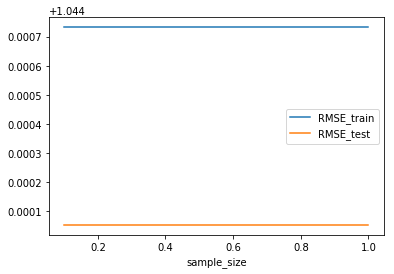

In [36]:
#Sample by size
sample_size = np.arange(1, 11, 1)/10

RMSE_train_mf2 = []
RMSE_test_mf2 = []

for ss in sample_size:
    ml_small = ml.sample(frac=ss, random_state = 50)
    RMSE_train, RMSE_test = mf_accuracy(ml_small, precision = False)
    RMSE_train_mf2.append(rmse_train)
    RMSE_test_mf2.append(rmse_test)
    
    
sample_plot2 = pd.DataFrame(
{
    'sample_size': sample_size,
    'RMSE_train': RMSE_train_mf2,
    'RMSE_test': RMSE_test_mf2
    
})



##plot the performance  by sample size
fig = sample_plot2.plot(x = 'sample_size', y = ['RMSE_train', 'RMSE_test'])
plt.show() 

In [37]:
sample_plot

,sample_size,RMSE_train,RMSE_test
0,0.1,1.046303,1.046530
1,0.2,1.044981,1.044407
2,0.3,1.043850,1.044020
3,0.4,1.047296,1.044586
4,0.5,1.044364,1.043583
5,0.6,1.043196,1.041525
6,0.7,1.044712,1.043583
7,0.8,1.044491,1.042195
8,0.9,1.045372,1.042866
9,1.0,1.044732,1.044053


For the MF model without side information, the RMSE is pretty stable as the sample size gets larger.

## FM with side information - movie

Here we add movie as a side information and include it as a feature when fitting the FM model.

In [10]:
movie_df = pd.read_csv("movies.csv")

#Deal with genres column
movie_genre = movie_df.loc[:,"genres"].str.split('|')
n_genre = []
for i in range(len(movie_genre)):
    num = len(movie_genre[i])
    n_genre.append(num)
movie_df["n_genre"] = n_genre
movie_genre = movie_genre.apply(pd.Series, 1).stack()
movie_genre.index = movie_genre.index.droplevel(-1)
movie_genre.name = "genres"
del movie_df["genres"]
movie_df = movie_df.join(movie_genre)

In [11]:
#Convert string into integers (representation of columns of matrix)
genre_list = ["Action","Adventure","Animation","Children","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir",
              "Horror","IMAX","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western","(no genres listed)"]
for i in range(len(genre_list)):
    movie_df["genres"].replace(genre_list[i], i, inplace = True)

In [12]:
#Convert genome-scores into csr matrix
movie_item = np.array(movie_df.loc[:,"movieId"] - 1)
movie_genre = np.array(movie_df.loc[:,"genres"])
movie_data = np.ones(movie_df.shape[0])
movie = sps.csr_matrix((movie_data, (movie_item, movie_genre)))
movie = normalize(movie, norm='l1', axis=1) #normalization

In [18]:
def feature_accuracy(ml, feature, precision = False):
    '''
    Input: 
        - ml: the selected dataframe of ratings
        
    Output:
        - RMSE_train, RMSE_test
        
    '''
    #Split training and test sets
    ml_train_df = ml.sample(frac=0.7, random_state = 50)
    ml_test_df = ml.drop(ml_train_df.index)
    
    #Shape here is the number of users (given by README.txt) * number of items (given by movies.csv)

    #Convert training set into coo matrix
    user_train = np.array(ml_train_df.loc[:,"userId"] - 1)
    item_train = np.array(ml_train_df.loc[:,"movieId"] - 1)
    rating_train = np.array(ml_train_df.loc[:,"rating"])
    ml_train = sps.coo_matrix((rating_train, (user_train, item_train)), shape = (138493, 131262))

    #Convert test set into coo matrix
    user_test = np.array(ml_test_df.loc[:,"userId"] - 1)
    item_test = np.array(ml_test_df.loc[:,"movieId"] - 1)
    rating_test = np.array(ml_test_df.loc[:,"rating"])
    ml_test = sps.coo_matrix((rating_test, (user_test, item_test)), shape = (138493, 131262))

    model = LightFM()
    %time model.fit(ml_train, item_features = feature)
    
    #Predict the model
    ml_train_pre = model.predict(user_train, item_train, item_features = feature)
    ml_train_pre = nmlz(ml_train_pre)
    ml_test_pre = model.predict(user_test, item_test, item_features = feature)
    ml_test_pre = nmlz(ml_test_pre)
    
    RMSE_train = compute_RMSE(ml_train_pre, rating_train)
    RMSE_test = compute_RMSE(ml_test_pre, rating_test)

    if precision == True:
    
        train_auc = auc_score(model, ml_train, item_features = feature).mean()
        test_auc = auc_score(model, ml_test, item_features = feature).mean()

        rank_train = model.predict_rank(ml_train, item_features = feature)
        train_recall = recallk(rank_train, ml_train, k=20).mean()
        train_precision = precisionk(rank_train, ml_train, k=20).mean()

            
        rank_test = model.predict_rank(ml_test, item_features = feature)
        test_recall = recallk(rank_test, ml_test, k=20).mean()
        test_precision = recallk(rank_test, ml_test, k=20).mean()
        
        start_time = time.time()
        train_auc = auc_score(model, ml_train, item_features = feature).mean()
        test_auc = auc_score(model, ml_test, item_features = feature).mean()
        print("AUC: --- %s seconds ---" % (time.time() - start_time))

        start_time = time.time()
        top_n_train, n_users_train, n_items_train = get_topn_nu_ni(ml_train_df, ml_train_pre)
        top_n_test, n_users_test, n_items_test = get_topn_nu_ni(ml_test_df, ml_test_pre)
        print("Top n: --- %s seconds ---" % (time.time() - start_time))

        start_time = time.time()
        ctcv_train = cata_cov(top_n_train, n_items_train)
        ctcv_test = cata_cov(top_n_test, n_items_test)
        print("Cata coverage: --- %s seconds ---" % (time.time() - start_time))

        start_time = time.time()
        uscv_train = user_cov(top_n_train, n_users_train)
        uscv_test = user_cov(top_n_test, n_users_test)
        print("User coverage: --- %s seconds ---" % (time.time() - start_time))

        start_time = time.time()
        itcv_train = item_cov(top_n_train, n_items_train)
        itcv_test = item_cov(top_n_test, n_items_test)
        print("Item coverage: --- %s seconds ---" % (time.time() - start_time))
    
        return RMSE_train, RMSE_test, train_precision, test_precision, train_recall, test_recall, train_auc, test_auc, ctcv_train, ctcv_test, uscv_train, uscv_test, itcv_train, itcv_test
    else:
        
        return RMSE_train, RMSE_test




In [15]:
iteration = 50
step = 5

RMSE_train_fm_m = []
RMSE_test_fm_m = []
AUC_train_fm_m = []
AUC_test_fm_m = []
Precision_train_fm_m = []
Precision_test_fm_m = []
Recall_train_fm_m = []
Recall_test_fm_m = []
CTCV_train_fm_m = []
CTCV_test_fm_m = []
USCV_train_fm_m = []
USCV_test_fm_m = []
ITCV_train_fm_m = []
ITCV_test_fm_m = []

index = int(len(user_movie)/iteration)
for i in range(0, iteration-step, step):
    size = list(range(i*index, (i+3)*index))
    user_selected = user_movie.iloc[size, 0]
    ml_selected = ml.loc[ml['userId'].isin(user_selected)]
    
    rmse_train, rmse_test, train_precision, test_precision, train_recall, test_recall, train_auc, test_auc, ctcv_train, ctcv_test, uscv_train, uscv_test, itcv_train, itcv_test = feature_accuracy(ml_selected, movie, precision = True)
    RMSE_train_fm_m.append(rmse_train)
    RMSE_test_fm_m.append(rmse_test)
    Precision_train_fm_m.append(train_precision)
    Precision_test_fm_m.append(test_precision)
    AUC_train_fm_m.append(train_auc)
    AUC_test_fm_m.append(test_auc)
    Recall_train_fm_m.append(train_recall)
    Recall_test_fm_m.append(test_recall)
    
    CTCV_train_fm_m.append(ctcv_train)
    CTCV_test_fm_m.append(ctcv_test)
    USCV_train_fm_m.append(uscv_train)
    USCV_test_fm_m.append(uscv_test)
    ITCV_train_fm_m.append(itcv_train)
    ITCV_test_fm_m.append(itcv_test)




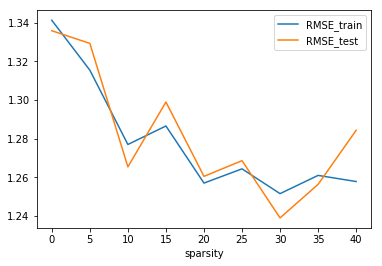

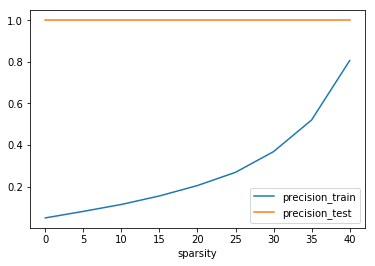

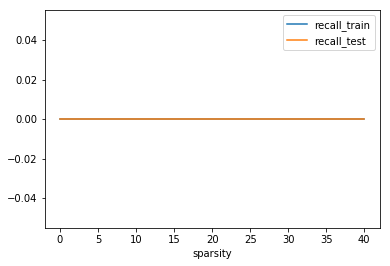

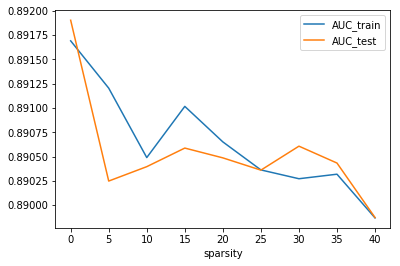

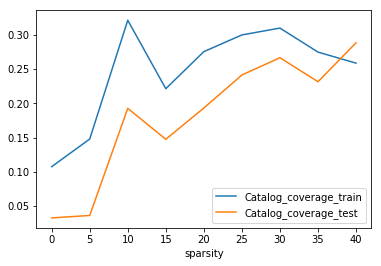

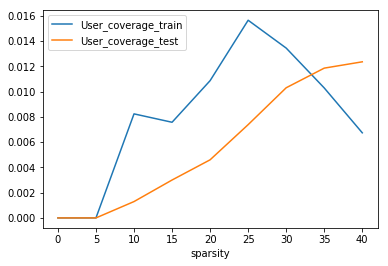

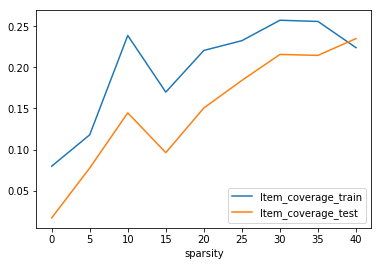

In [16]:
##Plot the performance of FM with movie feature
sample_plot = pd.DataFrame(
{
    'sparsity': list(range(0, iteration-step, step)),
    'RMSE_train': RMSE_train_fm_m,
    'RMSE_test': RMSE_test_fm_m,
    'precision_train': Precision_train_fm_m,
    'precision_test': Precision_test_fm_m,
    'recall_train': Recall_train_fm_m,
    'recall_test': Recall_test_fm_m,
    'AUC_train': AUC_train_fm_m,
    'AUC_test': AUC_test_fm_m,
    'Catalog_coverage_train': CTCV_train_fm_m,
    'Catalog_coverage_test': CTCV_test_fm_m,
    'User_coverage_train': USCV_train_fm_m,
    'User_coverage_test': USCV_test_fm_m,
    'Item_coverage_train': ITCV_train_fm_m,
    'Item_coverage_test': ITCV_test_fm_m
})
    

fig = sample_plot.plot(x = 'sparsity', y = ['RMSE_train', 'RMSE_test'])
plt.show() 
fig = sample_plot.plot(x = 'sparsity', y = ['precision_train', 'precision_test'])
plt.show() 
fig = sample_plot.plot(x = 'sparsity', y = ['recall_train', 'recall_test'])
plt.show()
fig = sample_plot.plot(x = 'sparsity', y = ['AUC_train', 'AUC_test'])
plt.show() 
fig = sample_plot.plot(x = 'sparsity', y = ['Catalog_coverage_train', 'Catalog_coverage_test'])
plt.show()
fig = sample_plot.plot(x = 'sparsity', y = ['User_coverage_train', 'User_coverage_test'])
plt.show()
fig = sample_plot.plot(x = 'sparsity', y = ['Item_coverage_train', 'Item_coverage_test'])
plt.show()

After adding the side information for the movie genre feature, both the RMSE have a decrease trend, and the metrics of coverage all increase as the dataset becomes dense.

CPU times: user 222 ms, sys: 10.3 ms, total: 232 ms
Wall time: 246 ms
CPU times: user 419 ms, sys: 10.3 ms, total: 429 ms
Wall time: 430 ms
CPU times: user 646 ms, sys: 10.9 ms, total: 657 ms
Wall time: 658 ms
CPU times: user 813 ms, sys: 12.7 ms, total: 825 ms
Wall time: 826 ms
CPU times: user 1.03 s, sys: 14.5 ms, total: 1.04 s
Wall time: 1.05 s
CPU times: user 1.24 s, sys: 16.6 ms, total: 1.26 s
Wall time: 1.26 s
CPU times: user 1.4 s, sys: 15.2 ms, total: 1.41 s
Wall time: 1.41 s
CPU times: user 1.59 s, sys: 15.8 ms, total: 1.61 s
Wall time: 1.61 s
CPU times: user 1.85 s, sys: 18.7 ms, total: 1.87 s
Wall time: 1.87 s
CPU times: user 1.98 s, sys: 16.9 ms, total: 1.99 s
Wall time: 1.99 s


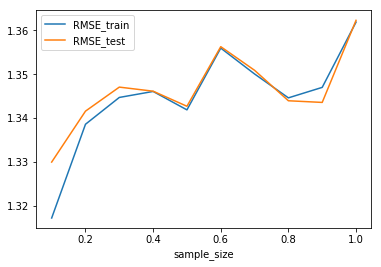

In [19]:
## subsample by sample size - FM with movie feature
sample_size = np.arange(1, 11, 1)/10

RMSE_train_fm_m2 = []
RMSE_test_fm_m2 = []


for ss in sample_size:
    ml_small = ml.sample(frac=ss, random_state = 50)
    rmse_train, rmse_test = feature_accuracy(ml_small, movie)
    RMSE_train_fm_m2.append(rmse_train)
    RMSE_test_fm_m2.append(rmse_test)

    
sample_plot = pd.DataFrame(
{
    'sample_size': sample_size,
    'RMSE_train': RMSE_train_fm_m2,
    'RMSE_test': RMSE_test_fm_m2
    
})



fig = sample_plot.plot(x = 'sample_size', y = ['RMSE_train', 'RMSE_test'])
plt.show() 



The result shows that as the sample size becomes larger, the RMSE actually increases. This can be explained by the change of sparsity. When there is an increase in the sample size, the dataset becomes more sparse instead of denser. Therefore, a sparsely-populated dataset might cause the increase in the error when we fit the model.

## FM with side information - genome

To further extend our model, we replace the movie genre feature with the genome score of movies as the new side information in our model and evaluate the results again.

In [20]:
geno_df = pd.read_csv("genome-scores.csv")

#Convert genome-scores into csr matrix
geno_item = np.array(geno_df.loc[:,"movieId"] - 1)
geno_tag = np.array(geno_df.loc[:,"tagId"] - 1)
geno_rlv = np.array(geno_df.loc[:,"relevance"])
geno = sps.csr_matrix((geno_rlv, (geno_item, geno_tag)), shape = (131262, 1128))

In [21]:
#Sample by users - MF with geno
iteration = 50
step = 5

RMSE_train_fm_g = []
RMSE_test_fm_g = []
AUC_train_fm_g = []
AUC_test_fm_g = []
Precision_train_fm_g = []
Precision_test_fm_g = []
Recall_train_fm_g = []
Recall_test_fm_g = []
CTCV_train_fm_g = []
CTCV_test_fm_g = []
USCV_train_fm_g = []
USCV_test_fm_g = []
ITCV_train_fm_g = []
ITCV_test_fm_g = []

index = int(len(user_movie)/iteration)
for i in range(0, iteration-step, step):
    size = list(range(i*index, (i+3)*index))
    user_selected = user_movie.iloc[size, 0]
    ml_selected = ml.iloc[user_selected, :]
    
    rmse_train, rmse_test, train_precision, test_precision, train_recall, test_recall, train_auc, test_auc, ctcv_train, ctcv_test, uscv_train, uscv_test, itcv_train, itcv_test = feature_accuracy(ml_selected, geno, precision = True)
    RMSE_train_fm_g.append(rmse_train)
    RMSE_test_fm_g.append(rmse_test)
    

    Precision_train_fm_g.append(train_precision)
    Precision_test_fm_g.append(test_precision)
    AUC_train_fm_g.append(train_auc)
    AUC_test_fm_g.append(test_auc)
    Recall_train_fm_g.append(train_recall)
    Recall_test_fm_g.append(test_recall)
    
    CTCV_train_fm_g.append(ctcv_train)
    CTCV_test_fm_g.append(ctcv_test)
    USCV_train_fm_g.append(uscv_train)
    USCV_test_fm_g.append(uscv_test)
    ITCV_train_fm_g.append(itcv_train)
    ITCV_test_fm_g.append(itcv_test)
    


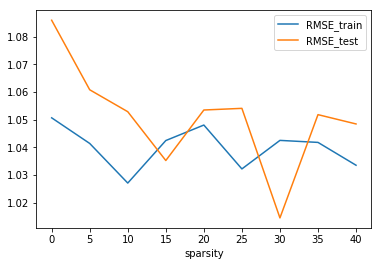

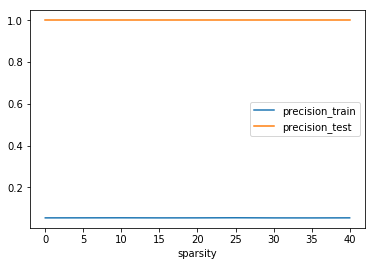

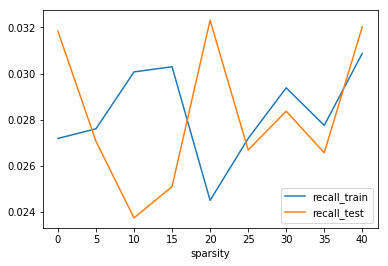

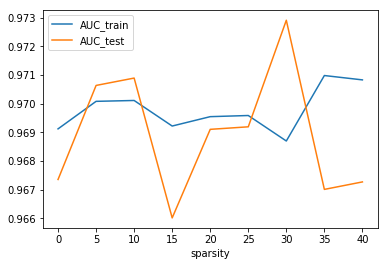

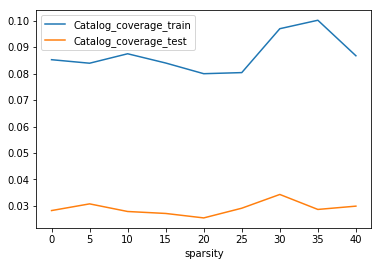

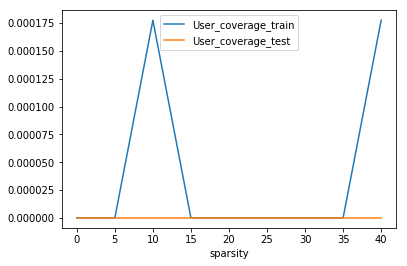

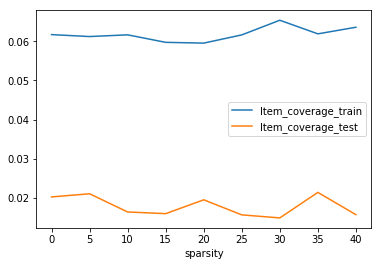

In [22]:
sample_plot = pd.DataFrame(
{
    'sparsity': list(range(0, iteration-step, step)),
    'RMSE_train': RMSE_train_fm_g,
    'RMSE_test': RMSE_test_fm_g,
    
    'precision_train': Precision_train_fm_g,
    'precision_test': Precision_test_fm_g,
    'recall_train': Recall_train_fm_g,
    'recall_test': Recall_test_fm_g,
    'AUC_train': AUC_train_fm_g,
    'AUC_test': AUC_test_fm_g,
    'Catalog_coverage_train': CTCV_train_fm_g,
    'Catalog_coverage_test': CTCV_test_fm_g,
    'User_coverage_train': USCV_train_fm_g,
    'User_coverage_test': USCV_test_fm_g,
    'Item_coverage_train': ITCV_train_fm_g,
    'Item_coverage_test': ITCV_test_fm_g
})

    

fig = sample_plot.plot(x = 'sparsity', y = ['RMSE_train', 'RMSE_test'])
plt.show() 
fig = sample_plot.plot(x = 'sparsity', y = ['precision_train', 'precision_test'])
plt.show() 
fig = sample_plot.plot(x = 'sparsity', y = ['recall_train', 'recall_test'])
plt.show()
fig = sample_plot.plot(x = 'sparsity', y = ['AUC_train', 'AUC_test'])
plt.show() 
fig = sample_plot.plot(x = 'sparsity', y = ['Catalog_coverage_train', 'Catalog_coverage_test'])
plt.show()
fig = sample_plot.plot(x = 'sparsity', y = ['User_coverage_train', 'User_coverage_test'])
plt.show()
fig = sample_plot.plot(x = 'sparsity', y = ['Item_coverage_train', 'Item_coverage_test'])
plt.show()

Using the new feature, the RMSE deceases and the AUC and coverage increase as the dataset becomes well-populated. However, the range of coverage is much lower than the previous model. Therefore, this model does not provide a better result comparing to the one with genre feature.

In [25]:
##Sample by size - MF with geno
sample_size = np.arange(1, 11, 1)/10

RMSE_train_fm_g2 = []
RMSE_test_fm_g2 = []

for ss in sample_size:
    ml_small = ml.sample(frac=ss, random_state = 50)
    rmse_train, rmse_test = feature_accuracy(ml_small, geno)
    RMSE_train_fm_g2.append(rmse_train)
    RMSE_test_fm_g2.append(rmse_test)





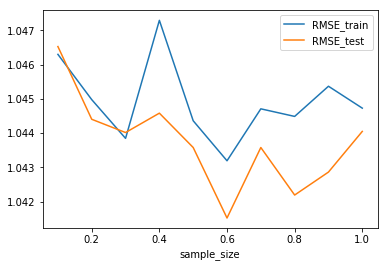

In [26]:
sample_plot = pd.DataFrame(
{
    'sample_size': sample_size,
    'RMSE_train': RMSE_train_fm_g2,
    'RMSE_test': RMSE_test_fm_g2
})





fig = sample_plot.plot(x = 'sample_size', y = ['RMSE_train', 'RMSE_test'])
plt.show() 

Here the RMSE drops by a small amount when the sample size is larger, which does not change the performance too much.

## Model Comparison

Now we compare the performance for the three models above with different metrics.

In [27]:
compare_metric = pd.DataFrame(
{
    'sparsity': list(range(0, iteration-step, step)),
    
    'RMSE_train_MF': RMSE_train_mf,
    'RMSE_test_MF': RMSE_test_mf,
    'precision_train_MF': Precision_train_mf,
    'precision_test_MF': Precision_test_mf,
    'AUC_train_MF': AUC_train_mf,
    'AUC_test_MF': AUC_test_mf,
    'Catalog_coverage_train_MF': CTCV_train_mf,
    'Catalog_coverage_test_MF': CTCV_test_mf,
    'User_coverage_train_MF': USCV_train_mf,
    'User_coverage_test_MF': USCV_test_mf,
    'Item_coverage_train_MF': ITCV_train_mf,
    'Item_coverage_test_MF': ITCV_test_mf,
    
    'RMSE_test_FM_movie': RMSE_test_fm_m,
    'precision_train_FM_movie': Precision_train_fm_m,
    'precision_test_FM_movie': Precision_test_fm_m,
    'recall_train_FM_movie': Recall_train_fm_m,
    'recall_test_FM_movie': Recall_test_fm_m,
    'AUC_train_FM_movie': AUC_train_fm_m,
    'AUC_test_FM_movie': AUC_test_fm_m,
    'Catalog_coverage_train_FM_movie': CTCV_train_fm_m,
    'Catalog_coverage_test_FM_movie': CTCV_test_fm_m,
    'User_coverage_train_FM_movie': USCV_train_fm_m,
    'User_coverage_test_FM_movie': USCV_test_fm_m,
    'Item_coverage_train_FM_movie': ITCV_train_fm_m,
    'Item_coverage_test_FM_movie': ITCV_test_fm_m,
    
    'RMSE_test_FM_geno': RMSE_test_fm_g,
    'precision_train_FM_geno': Precision_train_fm_g,
    'precision_test_FM_geno': Precision_test_fm_g,
    'recall_train_FM_geno': Recall_train_fm_g,
    'recall_test_FM_geno': Recall_test_fm_g,
    'AUC_train_FM_geno': AUC_train_fm_g,
    'AUC_test_FM_geno': AUC_test_fm_g,
    'Catalog_coverage_train_FM_geno': CTCV_train_fm_g,
    'Catalog_coverage_test_FM_geno': CTCV_test_fm_g,
    'User_coverage_train_FM_geno': USCV_train_fm_g,
    'User_coverage_test_FM_geno': USCV_test_fm_g,
    'Item_coverage_train_FM_geno': ITCV_train_fm_g,
    'Item_coverage_test_FM_geno': ITCV_test_fm_g
    
    
})


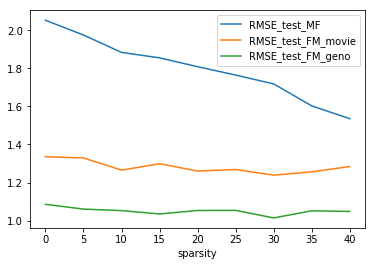

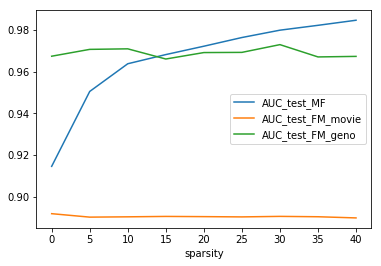

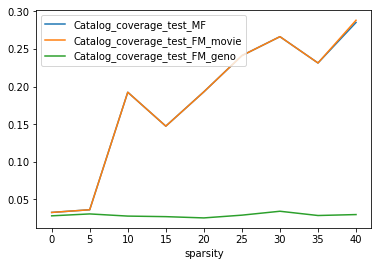

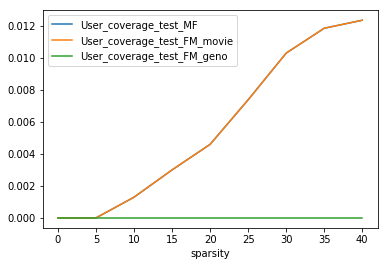

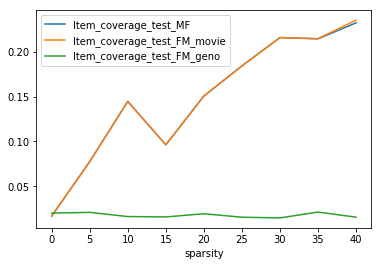

In [28]:
fig_rmse = compare_metric.plot(x = 'sparsity', y = ['RMSE_test_MF', 'RMSE_test_FM_movie', 'RMSE_test_FM_geno'])
plt.show() 

#fig_pre = compare_metric.plot(x = 'sparsity', y = ['precision_test_MF', 'precision_test_FM_movie', 'precision_test_FM_geno'])
# plt.show() 

#fig_recall = compare_metric.plot(x = 'sparsity', y = ['recall_test_MF', 'recall_test_FM_movie', 'recall_test_FM_geno'])
#plt.show() 
fig_auc = compare_metric.plot(x = 'sparsity', y = ['AUC_test_MF', 'AUC_test_FM_movie', 'AUC_test_FM_geno'])
plt.show() 
fig_cat = compare_metric.plot(x = 'sparsity', y = ['Catalog_coverage_test_MF', 'Catalog_coverage_test_FM_movie', 'Catalog_coverage_test_FM_geno'])
plt.show() 
fig_user = compare_metric.plot(x = 'sparsity', y = ['User_coverage_test_MF', 'User_coverage_test_FM_movie', 'User_coverage_test_FM_geno'])
plt.show() 
fig_item = compare_metric.plot(x = 'sparsity', y = ['Item_coverage_test_MF', 'Item_coverage_test_FM_movie', 'Item_coverage_test_FM_geno'])
plt.show() 




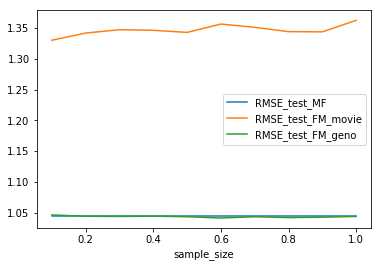

In [38]:
compare_metric2 = pd.DataFrame(
{
    'sample_size': sample_size,
    
    'RMSE_test_MF': RMSE_test_mf2,
    
    
    'RMSE_test_FM_movie': RMSE_test_fm_m2,
    
    
    'RMSE_test_FM_geno': RMSE_test_fm_g2,
    
})

fig_rmse = compare_metric2.plot(x = 'sample_size', y = ['RMSE_test_MF', 'RMSE_test_FM_movie', 'RMSE_test_FM_geno'])
plt.show() 


## Summary

In general, for models with and without side information, as the dataset becomes more and more well-populated (i.e. there is more information for each user/item), the error (RMSE) would decrease and the user/item/catalog coverage would increase. Similarly, these trends can be generated as the sample size becomes larger. However, this would lead to a much longer running time for factorization machine models. In addition, models with side information provides a lower RMSE comparing to the basic Matrix Factorization mode, which shows the benifit of adding other features in the Factorization Machine models. In our case, using genome score as the side information provides a lower error than using the basic MF model or the movie genre feature, whereas using movie genre as a feature provides a better result in increasing the coverage. Future work can be done using both features as side information, which requires a much longer running time. Also, the running time does not allow us to compare the coverage for different sample size, which can be improved in the future as well.